<a href="https://colab.research.google.com/github/mahapara2411/Sentiment-Analysis/blob/master/Pareto_NBD_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [368]:
!pip install lifetimes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [369]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import altair as alt
import plotly.express as px
import xlrd
import pandas as pd
import warnings
import lifetimes
import dill as pickle
from sklearn.cluster import KMeans
from lifetimes import ParetoNBDFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from sklearn.metrics import mean_squared_error, r2_score
import math
from math import sqrt
warnings.filterwarnings("ignore")
import datetime
np.random.seed(42)

In [370]:
data = pd.read_excel("Retail_cleaned_dataset.xlsx")

In [371]:
data["Total Amount"] = data["Quantity"]*data["Price"]

In [372]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Total Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2019-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2019-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2019-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2019-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [373]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(data, "CustomerID", "InvoiceDate", "Total Amount")

In [374]:
rfm_summary.reset_index(inplace = True)

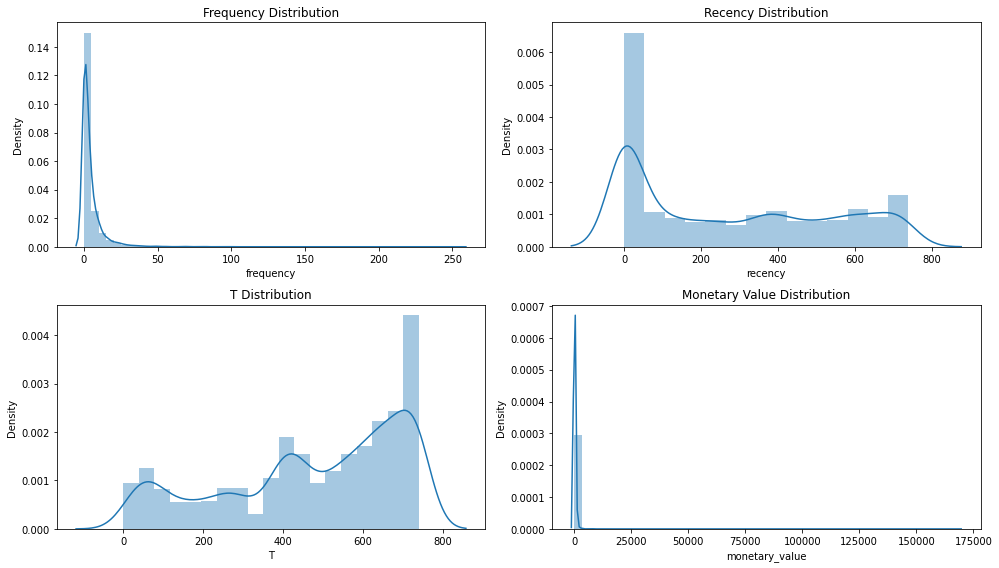

In [375]:
#plotting the distribution
plt.figure(figsize=(14,8))
plt.subplot(221)
sns.distplot(rfm_summary["frequency"])
plt.title("Frequency Distribution")
plt.subplot(222)
sns.distplot(rfm_summary["recency"])
plt.title("Recency Distribution")
plt.subplot(223)
sns.distplot(rfm_summary["T"])
plt.title("T Distribution")
plt.subplot(224)
sns.distplot(rfm_summary["monetary_value"])
plt.title("Monetary Value Distribution")
plt.tight_layout()

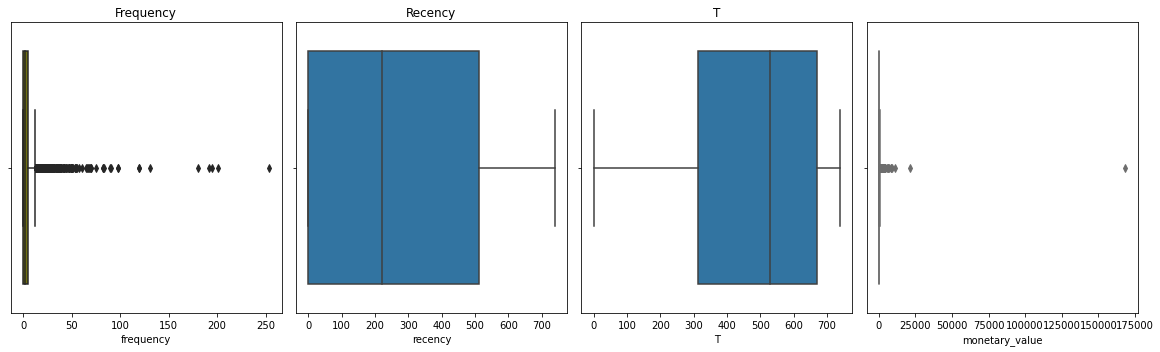

In [376]:
plt.figure(figsize=(16,5))
plt.subplot(141)
sns.boxplot(rfm_summary["frequency"], color = "olive")
plt.title("Frequency")
plt.subplot(142)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")
plt.subplot(143)
sns.boxplot(rfm_summary["T"])
plt.title("T")
plt.subplot(144)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")

plt.tight_layout()

In [377]:
rfm_summary.describe(percentiles = [0.01,0.1,0.25,0.50,0.75,0.90,0.99])

,CustomerID,frequency,recency,T,monetary_value
count,5878.000000,5878.000000,5878.000000,5878.000000,5878.000000
mean,15315.313542,4.632358,273.647669,474.551718,312.996561
std,1715.572666,9.999783,259.242435,223.394778,2255.743170
min,12346.000000,0.000000,0.000000,0.000000,0.000000
1%,12405.770000,0.000000,0.000000,15.000000,0.000000
10%,12936.700000,0.000000,0.000000,89.000000,0.000000
25%,13833.250000,0.000000,0.000000,313.000000,0.000000
50%,15314.500000,2.000000,221.000000,530.000000,207.117500
75%,16797.750000,5.000000,512.000000,669.000000,368.045909
90%,17696.300000,11.000000,668.000000,731.000000,591.139417


In [378]:
rfm_summary.head()

,CustomerID,frequency,recency,T,monetary_value
0,12346,7.0,401.0,726.0,11066.637143
1,12347,7.0,402.0,404.0,615.714286
2,12348,4.0,363.0,438.0,449.310000
3,12349,3.0,571.0,589.0,1120.056667
4,12350,0.0,0.0,310.0,0.000000


**Pareto/NBD Model**

In [379]:
def get_model(data, penalizer_val, time):
    
    pareto_result = data.copy()

    pareto_model = ParetoNBDFitter(penalizer_coef = penalizer_val)
    pareto_model.fit(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

    #calculating the predicted_purchases

    t = time

    pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])


    pareto_result["Actual_Purchases"] = pareto_result["frequency"]/pareto_result["recency"]*time

    #filling the null values
    pareto_result["Actual_Purchases"].fillna(0, inplace = True)


    #calculating the error
    pareto_result["Prediction_Error"] = pareto_result["Actual_Purchases"]-pareto_result["predicted_purchases"]

    #calcuating the purchase prediction error
    pareto_mse_purchase = mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_r2_purchase = r2_score(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"])
    pareto_rmse_purchase = sqrt(mean_squared_error(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"]))
    pareto_avg_error_purchase = pareto_result["Prediction_Error"].mean()
    
    #printing the purchase prediction error
    print("Predicted Purchase Mean Squared Error: %s" %(pareto_mse_purchase))
    print("Predicted Purchase R2 Score: %s" %(pareto_r2_purchase))
    print("Predicted Purchase Root Mean Squared Error: %s" %(pareto_rmse_purchase))
    print("Predicted Purchase Average Purchases Error: %s" %(pareto_avg_error_purchase))
    
    
    #plotting the prediction v/s actual purchase plot
    plt.figure(figsize=(6,4))
    plt.errorbar(pareto_result["Actual_Purchases"], pareto_result["predicted_purchases"], yerr=pareto_result["Prediction_Error"], fmt='o', color='darkseagreen',
                 ecolor='grey', elinewidth=1.5, capsize=0, alpha = 0.2);
    plt.title("Prediction v/s Actual")

Predicted Purchase Mean Squared Error: 2.2178054572100874
Predicted Purchase R2 Score: 0.060510353555273455
Predicted Purchase Root Mean Squared Error: 1.4892298201453285
Predicted Purchase Average Purchases Error: 0.23184043664196166


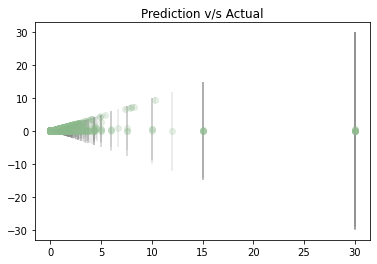

In [380]:
get_model(rfm_summary, 0.001, 30)

In [381]:
pareto_model = lifetimes.ParetoNBDFitter(penalizer_coef = 0.1)

In [382]:
pareto_model.fit(rfm_summary["frequency"],rfm_summary["recency"],
                rfm_summary["T"])

<lifetimes.ParetoNBDFitter: fitted with 5878 subjects, alpha: 72.03, beta: 385.66, r: 0.74, s: 0.18>

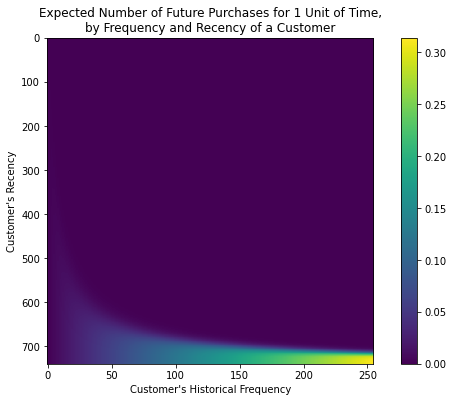

In [383]:
plt.figure(figsize=(10,6))
plot_frequency_recency_matrix(pareto_model)

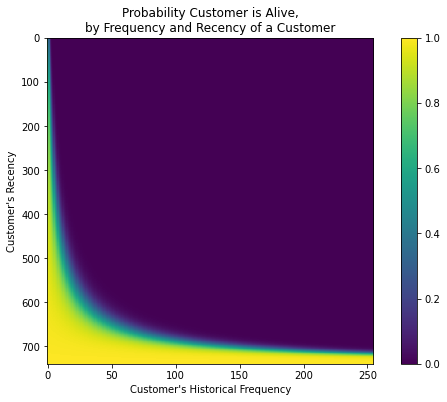

In [384]:
plt.figure(figsize=(10,6))
plot_probability_alive_matrix(pareto_model)

In [385]:
pareto_result = rfm_summary.copy()

In [386]:
pareto_result["p_not_alive"] = 1-pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])
pareto_result["p_alive"] = pareto_model.conditional_probability_alive(pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [387]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288


In [388]:
t = 30
pareto_result["predicted_purchases"] = pareto_model.conditional_expected_number_of_purchases_up_to_time(t, pareto_result["frequency"], pareto_result["recency"], pareto_result["T"])

In [389]:
pareto_result

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093
...,...,...,...,...,...,...,...,...
5873,18283,18.0,656.0,659.0,142.666667,0.000541,0.999459,0.766602
5874,18284,0.0,0.0,431.0,0.000000,0.222904,0.777096,0.034122
5875,18285,0.0,0.0,661.0,0.000000,0.309941,0.690059,0.020808
5876,18286,1.0,248.0,724.0,833.480000,0.201957,0.798043,0.052165


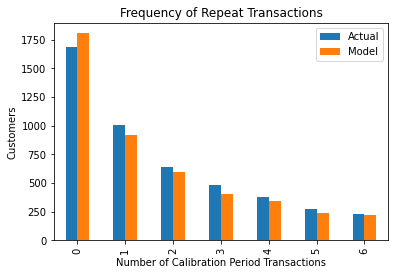

In [390]:
plot_period_transactions(pareto_model)

In [391]:
#dividing our dataset into training & holdout
pareto_summary_cal_holdout = calibration_and_holdout_data(data, "CustomerID", "InvoiceDate", 
                                                   calibration_period_end = '2021-06-08',
                                                  observation_period_end = '2021-12-09')

In [392]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [393]:
pareto_model.fit(pareto_summary_cal_holdout["frequency_cal"],
               pareto_summary_cal_holdout["recency_cal"],
               pareto_summary_cal_holdout["T_cal"])

<lifetimes.ParetoNBDFitter: fitted with 4960 subjects, alpha: 74.85, beta: 1619.38, r: 0.75, s: 0.69>

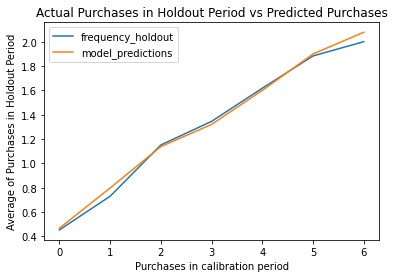

In [394]:
plot_calibration_purchases_vs_holdout_purchases(pareto_model, pareto_summary_cal_holdout)

In [395]:
pareto_summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12346,7.0,401.0,542.0,0.0,184.0
12347,3.0,158.0,220.0,4.0,184.0
12348,3.0,190.0,254.0,1.0,184.0
12349,2.0,182.0,405.0,1.0,184.0
12350,0.0,0.0,126.0,0.0,184.0


In [396]:
pareto_result["actual30"] = pareto_result["frequency"]/pareto_result["recency"]*30

In [397]:
pareto_result["actual30"].fillna(0, inplace = True)

In [398]:
pareto_result["error"] = pareto_result["actual30"]-pareto_result["predicted_purchases"]

In [399]:
pareto_result.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988
4,12350,0.0,0.0,310.0,0.000000,0.167712,0.832288,0.048093,0.000000,-0.048093


In [400]:
def get_metrics(true, predicted, error):
    
    print("Mean Squared Error: %s"%(mean_squared_error(true, predicted)))
    print("Root Mean Squared Error: %s"%(sqrt(mean_squared_error(true, predicted))))
    print("R2 Score: %s"%(r2_score(true, predicted)))
    
    sns.scatterplot(true, predicted, size = error, color = "darkolivegreen")
    plt.title("Actual Purchase v/s Predicted Purchase")
    plt.show()

Mean Squared Error: 2.2178118875611887
Root Mean Squared Error: 1.489231979095664
R2 Score: 0.060507629579523825


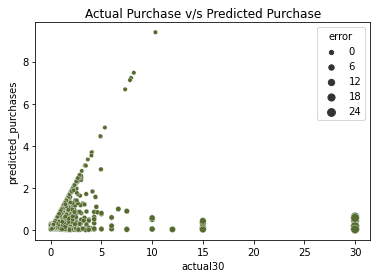

In [401]:
get_metrics(pareto_result["actual30"], pareto_result["predicted_purchases"], pareto_result["error"])

In [402]:
#Get the history alive plot to check whether the customer is alive or not

def get_history_alive(t_, data_, id_):
    
    individual_alive = data[data["CustomerID"] == id_]
    plot_history_alive(pareto_model, t = t_, transactions = individual_alive, datetime_col = "InvoiceDate",
                  freq = "D")

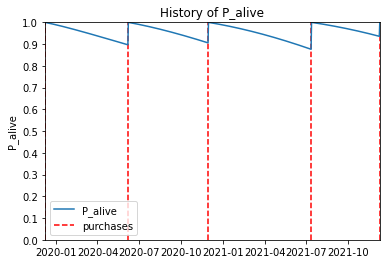

In [403]:
get_history_alive(30, data, 12358.0)

**GAMMA-GAMMA MODEL**

In [404]:
idx = pareto_result[(pareto_result["frequency"] <= 0.0)]

In [405]:
idx = idx.index

In [406]:
ggf_filter = pareto_result.drop(idx, axis = 0)

In [407]:
m_idx = ggf_filter[(ggf_filter["monetary_value"] <= 0.0)].index

In [408]:
ggf_filter = ggf_filter.drop(m_idx, axis = 0)

In [409]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

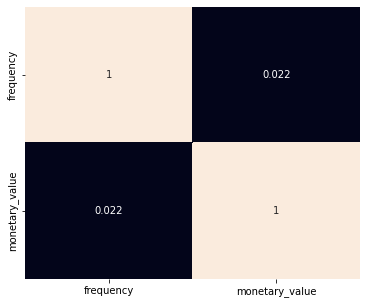

In [410]:
plt.figure(figsize=(6,5))
sns.heatmap(ggf_filter[["frequency", "monetary_value"]].corr(), annot = True, cbar = False)

In [411]:
ggf_model =  lifetimes.GammaGammaFitter(penalizer_coef=0.1)

In [412]:
ggf_model.fit(ggf_filter["frequency"], ggf_filter["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 4189 subjects, p: 1.02, q: 0.18, v: 0.93>

In [413]:
ggf_model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,1.019926,0.024531,0.971846,1.068006
q,0.179152,0.002996,0.173280,0.185023
v,0.933467,0.025489,0.883508,0.983426


In [414]:
ggf_filter["expected_avg_sales_"] = ggf_model.conditional_expected_average_profit(ggf_filter["frequency"],
                                                                                     ggf_filter["monetary_value"])

In [415]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899


In [416]:
print("Mean Squared Error: %s" %(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))
print("Root Mean Squared Error: %s" %(sqrt(mean_squared_error(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"]))))
print("R2 Score: %s" %(r2_score(ggf_filter["monetary_value"], ggf_filter["expected_avg_sales_"])))

Mean Squared Error: 118447363.6217067
Root Mean Squared Error: 10883.352591077195
R2 Score: -15.721908585813079


In [417]:
ggf_filter["predicted_clv"] = ggf_model.customer_lifetime_value(pareto_model,
                                                       ggf_filter["frequency"],
                                                       ggf_filter["recency"],
                                                       ggf_filter["T"],
                                                       ggf_filter["monetary_value"],
                                                       time = 30,
                                                       freq = 'D',
                                                       discount_rate = 0.01)

In [418]:
#Top 5 customers with high CLV
ggf_filter[["CustomerID", "predicted_clv"]].sort_values(by = "predicted_clv", ascending = False).head(5)

,CustomerID,predicted_clv
4061,16446,3.636526e+06
5692,18102,5.048913e+05
2277,14646,4.537431e+05
189,12536,3.626072e+05
5050,17450,2.876695e+05


In [419]:
# Assuming 5% of Profit Margin
ggf_filter["profit_margin"] = ggf_filter["predicted_clv"]*0.05

In [420]:
ggf_filter.reset_index().drop("index", axis = 1, inplace = True)

In [421]:
#exporting the result to csv
ggf_filter.to_csv("customer_lifetime_value_prediction.csv")

**CUSTOMER SEGMENTATION USING PREDICTED CLV**

In [422]:
ggf_filter.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834
6,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108


In [423]:
#col = ["predicted_purchases", "expected_avg_sales_", "predicted_clv", "profit_margin"]

In [424]:
#sns.pairplot(ggf_filter[col], diag_kind = "kde")

In [425]:
#new_df = ggf_filter[col]
#print(new_df)

In [426]:
# Standardizing data, so that all features have equal weight. This is important for modelling.
# Otherwise, in our case Income would be considered much more important than Education for Instance. 
# We do not know if this is the case, so we would not like to introduce it to our model. 
# This is what is also refered to as bias.
scaler = StandardScaler()
df_std = scaler.fit_transform(ggf_filter)

In [427]:
#For standardizing features. We'll use the StandardScaler module.
from sklearn.preprocessing import StandardScaler

In [428]:
inertia = []

for i in range(1, 11):
    kmeans  = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_std)
    inertia.append(kmeans.inertia_)

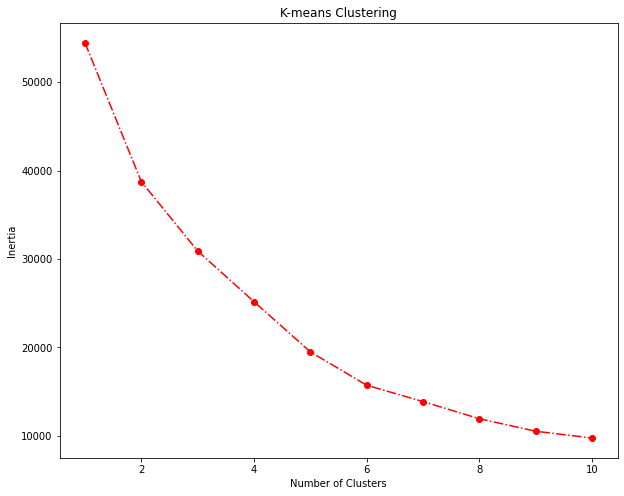

In [429]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means Clustering')
plt.show()

In [430]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [431]:
kmeans.fit(ggf_filter)

KMeans(n_clusters=4, random_state=42)

In [432]:
# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans= ggf_filter.copy()
df_segm_kmeans = pd.DataFrame(data = df_std,columns = ggf_filter.columns)
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [433]:
df_segm_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means
0,-1.741034,0.044158,0.074685,1.001239,3.993088,1.874412,-1.874412,-0.418804,-0.098714,0.007582,0.849625,0.492303,0.492303,0
1,-1.740446,0.044158,0.079073,-0.582848,0.066324,-0.561208,0.561208,0.314183,-0.099446,-0.184643,-0.025201,0.024313,0.024313,0
2,-1.739857,-0.220853,-0.092082,-0.415584,0.003800,-0.431021,0.431021,-0.162550,-0.207145,-0.171196,-0.035060,-0.048016,-0.048016,0
3,-1.739269,-0.309190,0.820745,0.327264,0.255822,-0.545045,0.545045,-0.389101,-0.304261,-0.212186,0.036679,-0.005644,-0.005644,0
4,-1.737503,0.132495,-0.122802,-0.641882,-0.037925,-0.498893,0.498893,0.469914,-0.014229,-0.137426,-0.048880,-0.026016,-0.026016,0


In [434]:
# Calculate mean values for the clusters
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,,,,,,,,,,
0,0.002026,-0.044840,-0.005577,0.000361,-0.025221,0.005683,-0.005683,-0.044508,-0.015575,-0.004438,-0.020565,-0.036526,-0.036526
1,0.672209,-0.485863,-0.785479,-1.561833,63.134696,-0.563655,0.563655,-0.347360,-0.310593,-0.229620,63.866298,61.791040,61.791040
2,-0.057797,5.808138,0.280948,-0.181292,2.611024,-0.448579,0.448579,6.118297,1.770751,0.228205,1.616202,5.569787,5.569787
3,-0.239068,3.884357,0.601316,0.042068,0.569203,-0.538851,0.538851,3.773341,1.407935,0.466530,0.233987,1.250432,1.250432


In [435]:
df_segm_analysis.rename({0:'Low',
                         1:'Very-High',
                         2:'High',
                         3:'Medium'})

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
Segment K-means,,,,,,,,,,,,,
Low,0.002026,-0.044840,-0.005577,0.000361,-0.025221,0.005683,-0.005683,-0.044508,-0.015575,-0.004438,-0.020565,-0.036526,-0.036526
Very-High,0.672209,-0.485863,-0.785479,-1.561833,63.134696,-0.563655,0.563655,-0.347360,-0.310593,-0.229620,63.866298,61.791040,61.791040
High,-0.057797,5.808138,0.280948,-0.181292,2.611024,-0.448579,0.448579,6.118297,1.770751,0.228205,1.616202,5.569787,5.569787
Medium,-0.239068,3.884357,0.601316,0.042068,0.569203,-0.538851,0.538851,3.773341,1.407935,0.466530,0.233987,1.250432,1.250432


In [436]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'Low',
                                                                  1:'Very-High',
                                                                  2:'High',
                                                                  3:'Medium'})

In [437]:
df_segm_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,Segment K-means,Labels
0,-1.741034,0.044158,0.074685,1.001239,3.993088,1.874412,-1.874412,-0.418804,-0.098714,0.007582,0.849625,0.492303,0.492303,0,Low
1,-1.740446,0.044158,0.079073,-0.582848,0.066324,-0.561208,0.561208,0.314183,-0.099446,-0.184643,-0.025201,0.024313,0.024313,0,Low
2,-1.739857,-0.220853,-0.092082,-0.415584,0.003800,-0.431021,0.431021,-0.162550,-0.207145,-0.171196,-0.035060,-0.048016,-0.048016,0,Low
3,-1.739269,-0.309190,0.820745,0.327264,0.255822,-0.545045,0.545045,-0.389101,-0.304261,-0.212186,0.036679,-0.005644,-0.005644,0,Low
4,-1.737503,0.132495,-0.122802,-0.641882,-0.037925,-0.498893,0.498893,0.469914,-0.014229,-0.137426,-0.048880,-0.026016,-0.026016,0,Low


In [438]:
#ggf_filter = pd.concat([ggf_filter,df_segm_kmeans['Segment K-means'],df_segm_kmeans['Labels']], axis = 1)

In [439]:
df_segm_kmeans.groupby('Labels').CustomerID.count()/ggf_filter.CustomerID.count()*100

Labels
High          0.190976
Low          98.925758
Medium        0.859394
Very-High     0.023872
Name: CustomerID, dtype: float64

In [440]:
ggf_filter.to_csv("Segmentation_result.csv")

**PCA**

In [441]:
# Employ PCA to find a subset of components, which explain the variance in the data.
from sklearn.decomposition import PCA
pca = PCA()

In [442]:
# Fit PCA with our standardized data.
pca.fit(df_std)

PCA()

In [443]:
# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([3.04724156e-01, 2.22744090e-01, 1.65367087e-01, 1.34654979e-01,
       8.53601995e-02, 7.53617960e-02, 5.63364720e-03, 3.10791384e-03,
       2.50451908e-03, 5.41612056e-04, 6.18323609e-33, 3.08616589e-33,
       7.76564673e-34])

Text(0, 0.5, 'Cumulative Explained Variance')

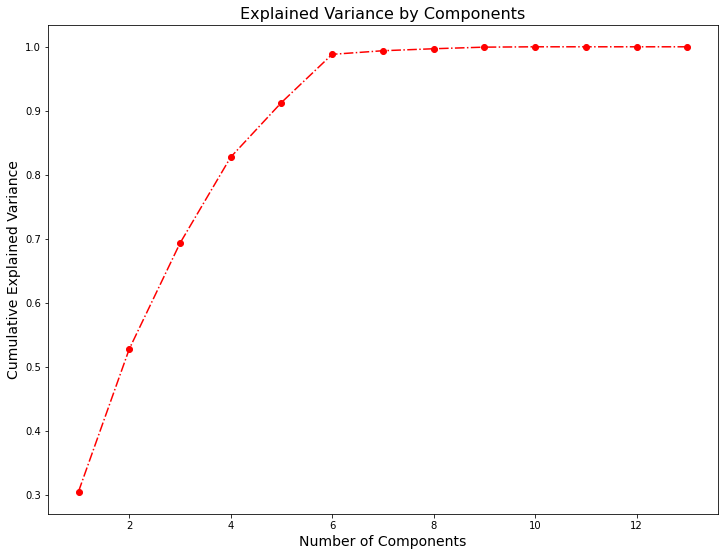

In [444]:
# Plot the cumulative variance explained by total number of components.
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (12,9))
plt.plot(range(1,14), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)

In [445]:
# We choose three components. 3 or 4 seems the right choice according to the previous graph.
pca = PCA(n_components = 6)

In [446]:
#Fit the model the our data with the selected number of components. In our case three.
pca.fit(df_std)

PCA(n_components=6)

In [447]:
# Here we discucss the results from the PCA.
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features. 
pca.components_

array([[-0.00159423,  0.07489253,  0.02718695, -0.01568405,  0.49359317,
        -0.05121845,  0.05121845,  0.0832527 ,  0.01752538, -0.00367083,
         0.4893811 ,  0.49888731,  0.49888731],
       [ 0.00358661,  0.33036232,  0.45923479,  0.1764029 , -0.06318041,
        -0.45023467,  0.45023467,  0.33305965, -0.19329743, -0.2863757 ,
        -0.08178111, -0.0348368 , -0.0348368 ],
       [ 0.01252666,  0.40709066, -0.01045352, -0.07080905, -0.06405408,
         0.01247442, -0.01247442,  0.43906525,  0.60525919,  0.50959507,
        -0.07540744, -0.00680224, -0.00680224],
       [ 0.02514828,  0.29360473,  0.29725702,  0.63281704,  0.02271165,
         0.44930507, -0.44930507,  0.04908592, -0.08526677, -0.10076952,
         0.00158112,  0.01099861,  0.01099861],
       [-0.3890763 ,  0.33251159, -0.38528458, -0.35610219, -0.0436449 ,
         0.19115989, -0.19115989,  0.41433607, -0.263144  , -0.37964902,
        -0.04908345,  0.01326484,  0.01326484],
       [-0.920722  , -0.124756

In [448]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = ggf_filter.columns,
                           index = ['Component 1', 'Component 2','Component 3','Component 4','Component 5','Component 6'])
df_pca_comp

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin
Component 1,-0.001594,0.074893,0.027187,-0.015684,0.493593,-0.051218,0.051218,0.083253,0.017525,-0.003671,0.489381,0.498887,0.498887
Component 2,0.003587,0.330362,0.459235,0.176403,-0.063180,-0.450235,0.450235,0.333060,-0.193297,-0.286376,-0.081781,-0.034837,-0.034837
Component 3,0.012527,0.407091,-0.010454,-0.070809,-0.064054,0.012474,-0.012474,0.439065,0.605259,0.509595,-0.075407,-0.006802,-0.006802
Component 4,0.025148,0.293605,0.297257,0.632817,0.022712,0.449305,-0.449305,0.049086,-0.085267,-0.100770,0.001581,0.010999,0.010999
Component 5,-0.389076,0.332512,-0.385285,-0.356102,-0.043645,0.191160,-0.191160,0.414336,-0.263144,-0.379649,-0.049083,0.013265,0.013265
Component 6,-0.920722,-0.124756,0.172360,0.167066,0.025714,-0.070087,0.070087,-0.167091,0.116283,0.163586,0.015328,-0.009110,-0.009110


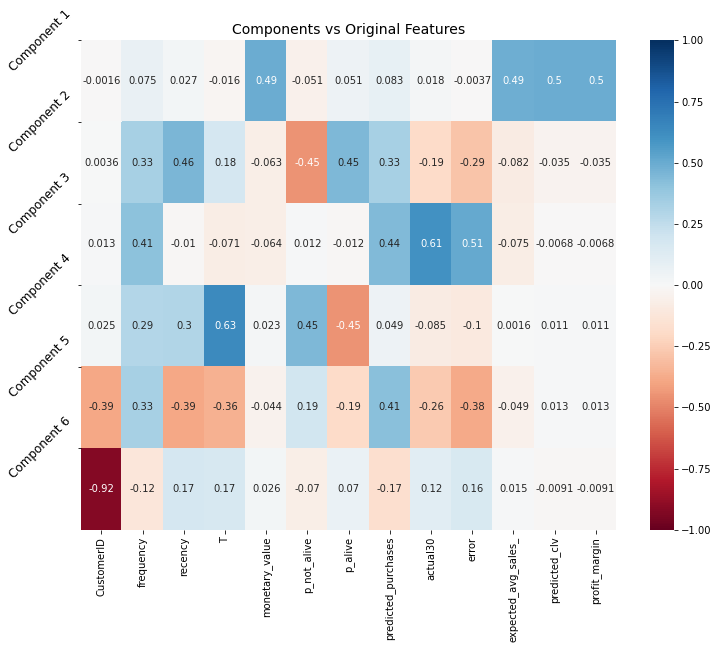

In [449]:
# Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2,3,4,5], 
           ['Component 1', 'Component 2','Component 3','Component 4','Component 5','Component 6'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [450]:
pca.transform(df_std)

array([[ 2.64173567, -1.94723267, -0.59505192,  2.39930556,  0.67003708,
         1.68137471],
       [ 0.1446153 ,  0.62011119,  0.00360148, -0.83593304,  0.87980869,
         1.4984896 ],
       [-0.0453255 ,  0.2342229 , -0.37299936, -0.76036856,  0.67461568,
         1.58009717],
       ...,
       [ 0.08393362,  1.87840617,  0.73952464,  0.67178942, -0.81597436,
        -1.52410625],
       [-0.01692832, -0.83130862, -0.82001916,  0.8119132 , -0.9170589 ,
        -1.51084467],
       [ 0.02822972,  0.79940741, -0.38884904, -0.08280332, -1.19376776,
        -1.40622482]])

In [451]:
scores_pca = pca.transform(df_std)

In [452]:
# We fit K means using the transformed data from the PCA.
inertia = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    inertia.append(kmeans_pca.inertia_)

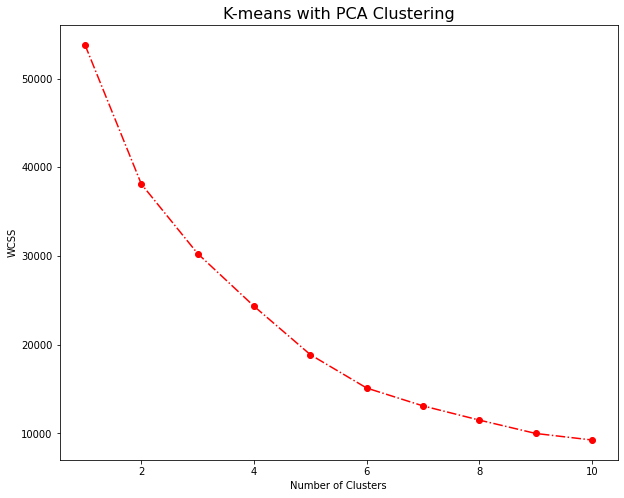

In [453]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), inertia, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering',fontsize = 16)
plt.show()

In [454]:
# We have chosen four clusters, so we run K-means with number of clusters equals four. 
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [455]:
# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [456]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([ggf_filter.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-2: ] = ['Component 1', 'Component 2']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [457]:
df_segm_pca_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,0,1,2,3,Component 1,Component 2,Segment K-means PCA
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,12504.444869,35175.087513,1758.754376,2.641736,-1.947233,-0.595052,2.399306,0.670037,1.681375,0
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,695.851861,7680.254014,384.012701,0.144615,0.620111,0.003601,-0.835933,0.879809,1.498490,1
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,562.775388,3430.871570,171.543579,-0.045325,0.234223,-0.372999,-0.760369,0.674616,1.580097,1
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,1531.122915,5920.276687,296.013834,0.154274,0.788273,-0.675208,-0.139262,-0.080956,1.914664,1
4,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,376.226899,4723.422157,236.171108,0.041305,0.523974,0.200608,-0.859185,1.059215,1.420852,1


In [458]:
# We calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,expected_avg_sales_,predicted_clv,profit_margin,0,1,2,3,Component 1,Component 2
Segment K-means PCA,,,,,,,,,,,,,,,,,,,
0,15269.356354,3.048343,151.682320,580.649171,349.676204,0.460356,0.539644,0.078034,0.970727,0.892693,944.632989,1.293603e+03,64.680134,-0.396131,-2.490012,-0.092305,1.373698,0.501280,-0.162562
1,15308.999131,7.242977,433.960904,511.142195,409.644623,0.033040,0.966960,0.400321,0.549449,0.149128,803.381911,6.221123e+03,311.056139,0.046648,0.558355,-0.036465,-0.276594,-0.072804,0.021597
2,16446.000000,1.000000,205.000000,205.000000,168469.600000,0.000000,1.000000,0.187433,0.146341,-0.041092,863116.959561,3.636526e+06,181826.302865,124.061246,-13.793811,-10.242810,1.072580,-4.005794,0.585299
3,15890.181818,1.000000,1.000000,280.454545,332.339091,0.284164,0.715836,0.225081,30.000000,29.774919,1707.439225,1.222344e+04,611.172224,0.150974,-10.130621,18.453316,-3.686514,-9.775426,3.866791


In [459]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','profit_margin']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'Medium', 
                                                          1:'Very-High',
                                                          2:'Low', 
                                                          3:'High'})
df_segm_pca_kmeans_freq

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,...,predicted_clv,profit_margin,0,1,2,3,Component 1,Component 2,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,,
Medium,15269.356354,3.048343,151.682320,580.649171,349.676204,0.460356,0.539644,0.078034,0.970727,0.892693,...,1.293603e+03,64.680134,-0.396131,-2.490012,-0.092305,1.373698,0.501280,-0.162562,724,0.172834
Very-High,15308.999131,7.242977,433.960904,511.142195,409.644623,0.033040,0.966960,0.400321,0.549449,0.149128,...,6.221123e+03,311.056139,0.046648,0.558355,-0.036465,-0.276594,-0.072804,0.021597,3453,0.824302
Low,16446.000000,1.000000,205.000000,205.000000,168469.600000,0.000000,1.000000,0.187433,0.146341,-0.041092,...,3.636526e+06,181826.302865,124.061246,-13.793811,-10.242810,1.072580,-4.005794,0.585299,1,0.000239
High,15890.181818,1.000000,1.000000,280.454545,332.339091,0.284164,0.715836,0.225081,30.000000,29.774919,...,1.222344e+04,611.172224,0.150974,-10.130621,18.453316,-3.686514,-9.775426,3.866791,11,0.002626


In [460]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Medium', 
                                                          1:'Low',
                                                          2:'Very-High', 
                                                          3:'High'})

In [461]:
df_segm_pca_kmeans.head()

,CustomerID,frequency,recency,T,monetary_value,p_not_alive,p_alive,predicted_purchases,actual30,error,...,predicted_clv,profit_margin,0,1,2,3,Component 1,Component 2,Segment K-means PCA,Legend
0,12346,7.0,401.0,726.0,11066.637143,0.465187,0.534813,0.155209,0.523691,0.368482,...,35175.087513,1758.754376,2.641736,-1.947233,-0.595052,2.399306,0.670037,1.681375,0,Medium
1,12347,7.0,402.0,404.0,615.714286,0.000467,0.999533,0.485818,0.522388,0.036570,...,7680.254014,384.012701,0.144615,0.620111,0.003601,-0.835933,0.879809,1.498490,1,Low
2,12348,4.0,363.0,438.0,449.310000,0.025307,0.974693,0.270791,0.330579,0.059788,...,3430.871570,171.543579,-0.045325,0.234223,-0.372999,-0.760369,0.674616,1.580097,1,Low
3,12349,3.0,571.0,589.0,1120.056667,0.003551,0.996449,0.168606,0.157618,-0.010988,...,5920.276687,296.013834,0.154274,0.788273,-0.675208,-0.139262,-0.080956,1.914664,1,Low
4,12352,8.0,356.0,392.0,338.261250,0.012357,0.987643,0.556060,0.674157,0.118098,...,4723.422157,236.171108,0.041305,0.523974,0.200608,-0.859185,1.059215,1.420852,1,Low


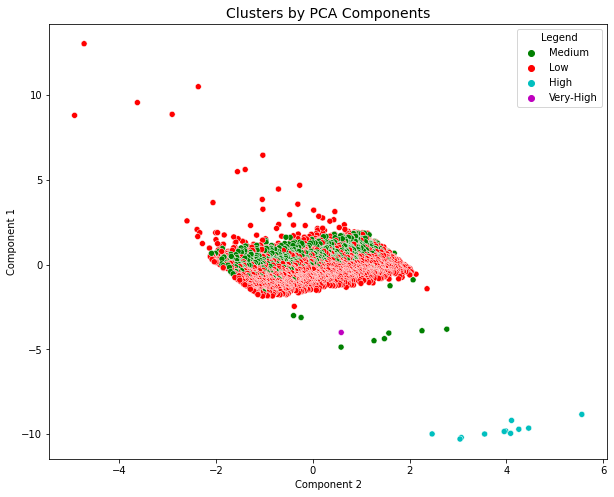

In [462]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
plt.show()

In [465]:
df_segm_pca_kmeans.groupby('Legend').CustomerID.count()/df_segm_pca_kmeans.CustomerID.count()*100

Legend
High          0.262593
Low          82.430174
Medium       17.283361
Very-High     0.023872
Name: CustomerID, dtype: float64

In [466]:
df_segm_pca_kmeans.to_csv("Customer_Segmentation_result_PCA.csv")